### Application of GPcounts with Negative Binomial likelihood on spatial data from Mouse olfactory bulb to identify spatially expressed genes. 

In the following example, we use Mouse olfactory bulb spatially dependent data-set, published by <a href="https://science.sciencemag.org/content/353/6294/78" target="_blank">Stahl et al.</a>. 
To correct for the library size of the spatial samples, we normalise our data by multiplying the mean by a location specific scale factor. To calculate the scale factors we perform negative binomial regression with identity link function using the glm function with negative binomial and identity link function as implemented below. 


In [1]:
import pandas as pd 
import numpy as np 
import gpflow
import tensorflow as tf
from GPcounts import NegativeBinomialLikelihood
from GPcounts.RNA_seq_GP import rna_seq_gp
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

We load the expression matrix and extract the spatial locations 'x' and 'y'

In [2]:
# spatial expression counts matrix
Y = pd.read_csv('../data/MouseOB/Rep11_MOB_0.csv', index_col=[0])
Y = Y.T[Y.sum(0) >= 3].T # Filter out genes with less than 3 total counts

In [3]:
spatial_locations = pd.DataFrame(index=Y.index)
spatial_locations['x'] = Y.index.str.split('x').str.get(0).map(float)
spatial_locations['y'] = Y.index.str.split('x').str.get(1).map(float)

In [4]:
spatial_locations['total_counts'] = Y.sum(1)
Y = Y.loc[spatial_locations.index]
X = spatial_locations[['x', 'y']]
# scale = pd.read_csv('../data/MouseOB/scales_nb.txt', sep="\t") # load the file with the scale factors 

Calculate the scale coefficients

In [5]:
import statsmodels.formula.api as smf 
import statsmodels.api as sm
scales = []
for i in range(0,len(Y.columns)):
    model=smf.glm(formula = "Y.iloc[:,i]~0+spatial_locations['total_counts']", data=Y,family=sm.families.NegativeBinomial(sm.families.links.identity())).fit()
    res = model.params[0]*spatial_locations['total_counts']
    scales.append(res)
scalesdf=pd.DataFrame(scales)
scalesdf=scalesdf.T

/Users/nuhasaud/anaconda3/envs/GPC_test_3.12/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/nuhasaud/anaconda3/envs/GPC_test_3.12/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The identity link function does not respect the domain of the NegativeBinomial family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/Users/nuhasaud/anaconda3/envs/GPC_test_3.12/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/nuhasaud/anaconda3/envs/GPC_test_3.12/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWa

In [6]:
print(scalesdf.head())

               total_counts  total_counts  total_counts  total_counts  \
16.92x9.015        0.358224      0.378969      1.334467      0.971175   
16.945x11.075      0.705199      0.746039      2.627032      1.911856   
16.97x10.118       0.237754      0.251523      0.885691      0.644573   
16.939x12.132      0.432823      0.457889      1.612368      1.173421   
16.949x13.055      0.355383      0.375964      1.323885      0.963474   

               total_counts  total_counts  total_counts  total_counts  \
16.92x9.015        0.874044      3.135066      0.604092      1.643130   
16.945x11.075      1.720643      6.171691      1.189216      3.234667   
16.97x10.118       0.580106      2.080756      0.400939      1.090552   
16.939x12.132      1.056063      3.787940      0.729894      1.985311   
16.949x13.055      0.867113      3.110205      0.599302      1.630101   

               total_counts  total_counts  ...  total_counts  total_counts  \
16.92x9.015        1.792824      0.905178  .

After filtering, the whole data-set contains 14,859 genes but for simplicity we run this example on the first 20 genes. This will take a few minutes. For the purposes of comparison, we provide a file (../data/MouseOB/SE_genes_comparison.csv) with the all spatially expressed genes found by running GPcounts on the whole data-set as well as the spatially expressed genes identified by [SpatialDE](https://github.com/Teichlab/SpatialDE/tree/cb5deb8c24e7c98c77672784b43cef41b2f24d99) package.    

In [7]:
Y = Y.T
Y_run = Y.iloc[0:20,:] # select first 20 genes to run GPcounts
X = X[['x', 'y']]

To run the scaled version of the GPcounts, where the negative binomial mean is multiplied by the pre-calculated scale factors (scalesdf), we should use the three optional arguments in the function Fit_GPcounts:  'scale=scalesdf' and 'nb_scaled'.
The 'scale' argument contains the file with the scale factors, the 'nb_scaled=True' argument is used to  activate the scaled (multiplicative) version.  

In [8]:
gene_name = []
nb_scaled = True # set the nb_scaled argument to True to pass the scale factors 
gene_name = Y_run.index
likelihood = 'Negative_binomial' 
gp_counts = rna_seq_gp(X,Y_run.loc[gene_name], scale = scalesdf, safe_mode=False)

We run the One_sample_test with negative binomial likelihood for the 20 genes. Then we run gp_counts.calculate_FDR and the 'results' will show the following:

* Name of the gene
* Dynamic_model_log_likelihood - Likelihood of the dynamic model  
* Constant_model_log_likelihood - Likelihood of the constant ('null') model
* log_likelihood_ratio - Ratio between the dynamic and constant models
* p value - statistical significance based on P value 
* q value - Statistical significance based on the "adjusted p value" for the false discovery rate or q value 

In [9]:
log_likelihood_ratio = gp_counts.One_sample_test(likelihood)
log_likelihood_ratio

100%|███████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]


Dynamic_model_log_likelihood  Constant_model_log_likelihood  \
Nrf1                            -249.249995                    -249.515088   
Zbtb5                           -264.375801                    -264.404122   
Ccnl1                           -470.155381                    -470.182132   
Lrrfip1                         -425.484372                    -426.374136   
Bbs1                            -399.719524                    -399.765082   
Lix1                            -613.495949                    -615.966548   
Whrn                            -343.357926                    -344.281663   
Ate1                            -504.470200                    -506.274614   
Ubac1                           -519.843176                    -519.901397   
Rab34                           -404.388548                    -404.388553   
Nap1l1                          -701.963736                    -707.910775   
Srgap3                          -645.942903                    -646.256565   
Slc1a3                         -1112.121937                   -1123.880587   
Polr3k                          -360.316253                    -360.316250   
Inpp5f                          -637.347014                    -638.242185   
Ndufaf6                         -215.293855                    -215.294453   
Atp5j2                          -669.358003                    -671.063380   
Tnpo2                           -516.473990                    -516.475587   
2010300C02Rik                   -660.594305                    -683.360355   
B3gat3                          -531.778596                    -534.353450   

               log_likelihood_ratio  
Nrf1                       0.265092  
Zbtb5                      0.028320  
Ccnl1                      0.026752  
Lrrfip1                    0.889764  
Bbs1                       0.045557  
Lix1                       2.470599  
Whrn                       0.923737  
Ate1                       1.804414  
Ubac1                      0.058221  
Rab34                      0.000005  
Nap1l1                     5.947039  
Srgap3                     0.313663  
Slc1a3                    11.758649  
Polr3k                    -0.000002  
Inpp5f                     0.895171  
Ndufaf6                    0.000598  
Atp5j2                     1.705377  
Tnpo2                      0.001597  
2010300C02Rik             22.766051  
B3gat3                     2.574854

In [10]:
results = gp_counts.calculate_FDR(log_likelihood_ratio)
results

Dynamic_model_log_likelihood  Constant_model_log_likelihood  \
Nrf1                            -249.249995                    -249.515088   
Zbtb5                           -264.375801                    -264.404122   
Ccnl1                           -470.155381                    -470.182132   
Lrrfip1                         -425.484372                    -426.374136   
Bbs1                            -399.719524                    -399.765082   
Lix1                            -613.495949                    -615.966548   
Whrn                            -343.357926                    -344.281663   
Ate1                            -504.470200                    -506.274614   
Ubac1                           -519.843176                    -519.901397   
Rab34                           -404.388548                    -404.388553   
Nap1l1                          -701.963736                    -707.910775   
Srgap3                          -645.942903                    -646.256565   
Slc1a3                         -1112.121937                   -1123.880587   
Polr3k                          -360.316253                    -360.316250   
Inpp5f                          -637.347014                    -638.242185   
Ndufaf6                         -215.293855                    -215.294453   
Atp5j2                          -669.358003                    -671.063380   
Tnpo2                           -516.473990                    -516.475587   
2010300C02Rik                   -660.594305                    -683.360355   
B3gat3                          -531.778596                    -534.353450   

               log_likelihood_ratio       p_value       q_value  
Nrf1                       0.265092  4.665291e-01  7.775485e-01  
Zbtb5                      0.028320  8.118864e-01  1.000000e+00  
Ccnl1                      0.026752  8.170759e-01  1.000000e+00  
Lrrfip1                    0.889764  1.822073e-01  3.644147e-01  
Bbs1                       0.045557  7.627645e-01  1.000000e+00  
Lix1                       2.470599  2.622384e-02  1.048954e-01  
Whrn                       0.923737  1.740775e-01  3.644147e-01  
Ate1                       1.804414  5.747361e-02  1.850654e-01  
Ubac1                      0.058221  7.329253e-01  1.000000e+00  
Rab34                      0.000005  9.974703e-01  1.000000e+00  
Nap1l1                     5.947039  5.631271e-04  3.754180e-03  
Srgap3                     0.313663  4.283381e-01  7.775485e-01  
Slc1a3                    11.758649  1.237957e-06  1.237957e-05  
Polr3k                    -0.000002  1.000000e+00  1.000000e+00  
Inpp5f                     0.895171  1.808845e-01  3.644147e-01  
Ndufaf6                    0.000598  9.724102e-01  1.000000e+00  
Atp5j2                     1.705377  6.477288e-02  1.850654e-01  
Tnpo2                      0.001597  9.549354e-01  1.000000e+00  
2010300C02Rik             22.766051  1.501577e-11  3.003153e-10  
B3gat3                     2.574854  2.325029e-02  1.048954e-01

Plot some spatially expressed genes from the data-set based on the q values provided in file 'SE_genes_comparison.csv'

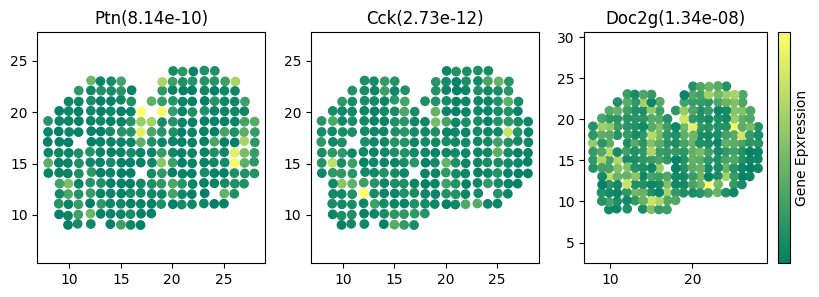

In [11]:
from matplotlib import rcParams
plt.rcParams["figure.figsize"] = [10,3]
m = ['Ptn(8.14e-10)', 'Cck(2.73e-12)', 'Doc2g(1.34e-08)']
for i, g in enumerate(['Ptn', 'Cck', 'Doc2g']):
    plt.subplot(1, 3, i + 1)
    plt.scatter(spatial_locations['x'], spatial_locations['y'], c=Y.T[g],cmap = 'summer')
    # plt.figure(figsize=(10,3))
    plt.title(m[i])
    plt.axis('equal')
plt.colorbar(ticks=[0,1],label = 'Gene Epxression')

plt.show()


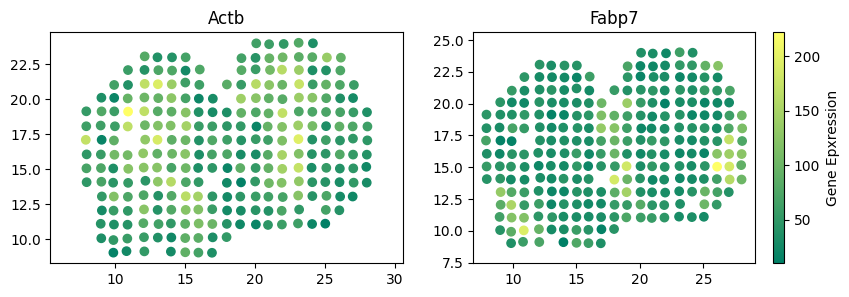

In [12]:
from matplotlib import rcParams
plt.rcParams["figure.figsize"] = [10,3]
m = ['Actb', 'Fabp7']
for i, g in enumerate(['Actb', 'Fabp7']):
    plt.subplot(1, 2, i + 1)
    plt.scatter(spatial_locations['x'], spatial_locations['y'], c=Y.T[g],cmap = 'summer')
    # plt.figure(figsize=(10,3))
    plt.title(m[i])
    plt.axis('equal')
plt.colorbar(label = 'Gene Epxression')

# plt.show()
plt.savefig('svgenes_1.pdf')

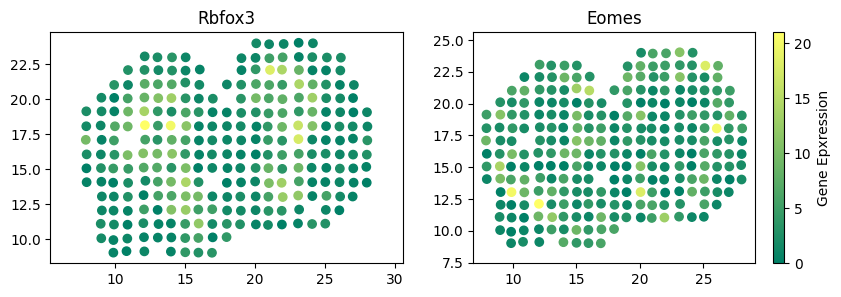

In [13]:
from matplotlib import rcParams
plt.rcParams["figure.figsize"] = [10,3]
m = ['Rbfox3', 'Eomes']
for i, g in enumerate(['Rbfox3', 'Eomes']):
    plt.subplot(1, 2, i + 1)
    plt.scatter(spatial_locations['x'], spatial_locations['y'], c=Y.T[g],cmap = 'summer')
    # plt.figure(figsize=(10,3))
    plt.title(m[i])
    plt.axis('equal')
plt.colorbar(label = 'Gene Epxression')
plt.savefig('svgenes_2.pdf')
# plt.show()

 We plot two genes with very low expression which have been identified as spatially expressed by SpatialDE but not by GPcounts 

In [ ]:
plt.rcParams["figure.figsize"] = [10,3]
n = ['Olfr635','Gna14', 'Taf7l']
for i, g in enumerate(['Olfr635','Gna14', 'Taf7l']):
    plt.subplot(1, 3, i + 1)
    plt.scatter(spatial_locations['x'], spatial_locations['y'], c=Y.T[g],cmap = 'summer')
    # plt.figure(figsize=(10,3))
    plt.title(n[i])
    plt.axis('equal')
plt.colorbar(label = 'Gene Epxression')